In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import ast
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.utils import resample
import seaborn as sns
from matplotlib import pyplot as plt

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Optional plotting function
if True:
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })

def bootstrap_ci(y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    bootstrapped_scores = {'auroc': [], 'auprc': []}
    indices = np.arange(len(y_true))
    for _ in range(n_bootstraps):
        sampled_indices = resample(indices, replace=True)
        bootstrapped_scores['auroc'].append(roc_auc_score(y_true[sampled_indices], y_pred[sampled_indices]))
        bootstrapped_scores['auprc'].append(average_precision_score(y_true[sampled_indices], y_pred[sampled_indices]))

    ci = {}
    for score_type in bootstrapped_scores:
        sorted_scores = np.sort(bootstrapped_scores[score_type])
        lower = np.percentile(sorted_scores, 100 * alpha / 2)
        upper = np.percentile(sorted_scores, 100 * (1 - alpha / 2))
        mean = np.mean(sorted_scores)
        ci[score_type] = (lower, mean, upper)
    return ci
    

In [5]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

alldata['xscore'] = 0.0
alldata.loc[alldata['phase'] == 0.5, 'xscore'] = 1*0.732*0.548*0.580*0.911
alldata.loc[alldata['phase'] == 1, 'xscore'] = 1*0.732*0.548*0.580
alldata.loc[alldata['phase'] == 2, 'xscore'] = 1*0.732*0.548
alldata.loc[alldata['phase'] == 3, 'xscore'] = 1*0.732
alldata.loc[alldata['phase'] == 4, 'xscore'] = 1

indata = alldata.loc[alldata['drug_gene'] == 1]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]
print(indata['phecode'].nunique())

#####

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']


112


## Logistic regressions

#### Main

In [4]:
results = []

conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

for cond in conds:
    pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
    pdf = pdf.merge(indata[['id','phecode_category']]).sort_values('prediction',ascending=False)
    pdf['percentile'] = pdf['prediction'].rank(pct=True) * 100
    pdf.loc[((pdf['percentile'] > 25) & (pdf['percentile'] < 75)), ['p_90','p_95','p_97','p_99']] = 0
    pdf.loc[(pdf['percentile'] >= 90) & (pdf['percentile'] < 95), 'p_90'] = 1
    pdf.loc[(pdf['percentile'] >= 95) & (pdf['percentile'] < 97), 'p_95'] = 1
    pdf.loc[(pdf['percentile'] >= 97) & (pdf['percentile'] < 99), 'p_97'] = 1
    pdf.loc[pdf['percentile'] >= 99, 'p_99'] = 1
    
    for col in ['p_90','p_95','p_97','p_99']:
        temp = pdf.dropna(subset=col)
        X = temp[['phecode_category'] + [col]]
        X = pd.get_dummies(X, columns=['phecode_category'], drop_first=True).astype(float)
        X = sm.add_constant(X)
        y = temp['indication']
        
        model = sm.Logit(y, X)
        res = model.fit(disp=0, maxiter=1000)
        
        odds_ratio = np.exp(res.params[col])
        conf = res.conf_int().loc[col]
        conf_odds_ratio = np.exp(conf)
        p_value = res.pvalues[col]
        
        results.append({
            'Condition': cond,
            'Percentile': col,
            'Odds Ratio': odds_ratio,
            '95% Lower': conf_odds_ratio[0],
            '95% Upper': conf_odds_ratio[1],
            'p-value': p_value
        })

res_df = pd.DataFrame(results)
res_df['Condition'] = res_df['Condition'].map({'ot':'Existing',
                                             'mantis':'Mantis-ML','cc':'Genetic associations',
                                             'ot_mantis':'Mantis-ML + Existing',
                                             'ot_mantis_cc':'RareGPS'})

res_df.to_pickle('./Results/or_90_95_97.pkl')


In [5]:
res_df

,Condition,Percentile,Odds Ratio,95% Lower,95% Upper,p-value
0,Existing,p_90,3.510997,3.223863,3.823705,4.993136e-183
1,Existing,p_95,5.603238,5.037144,6.232951,1.000710e-220
2,Existing,p_97,5.391250,4.839045,6.006469,4.414858e-205
3,Existing,p_99,10.590802,9.439939,11.881971,0.000000e+00
4,Mantis-ML,p_90,2.540088,2.272917,2.838665,9.867275e-61
5,Mantis-ML,p_95,2.904749,2.491739,3.386217,2.748002e-42
6,Mantis-ML,p_97,3.173817,2.738484,3.678354,3.915812e-53
7,Mantis-ML,p_99,6.740322,5.821450,7.804230,1.256048e-143
8,Genetic associations,p_90,1.358536,1.219875,1.512958,2.429863e-08
9,Genetic associations,p_95,1.331924,1.129875,1.570104,6.385757e-04


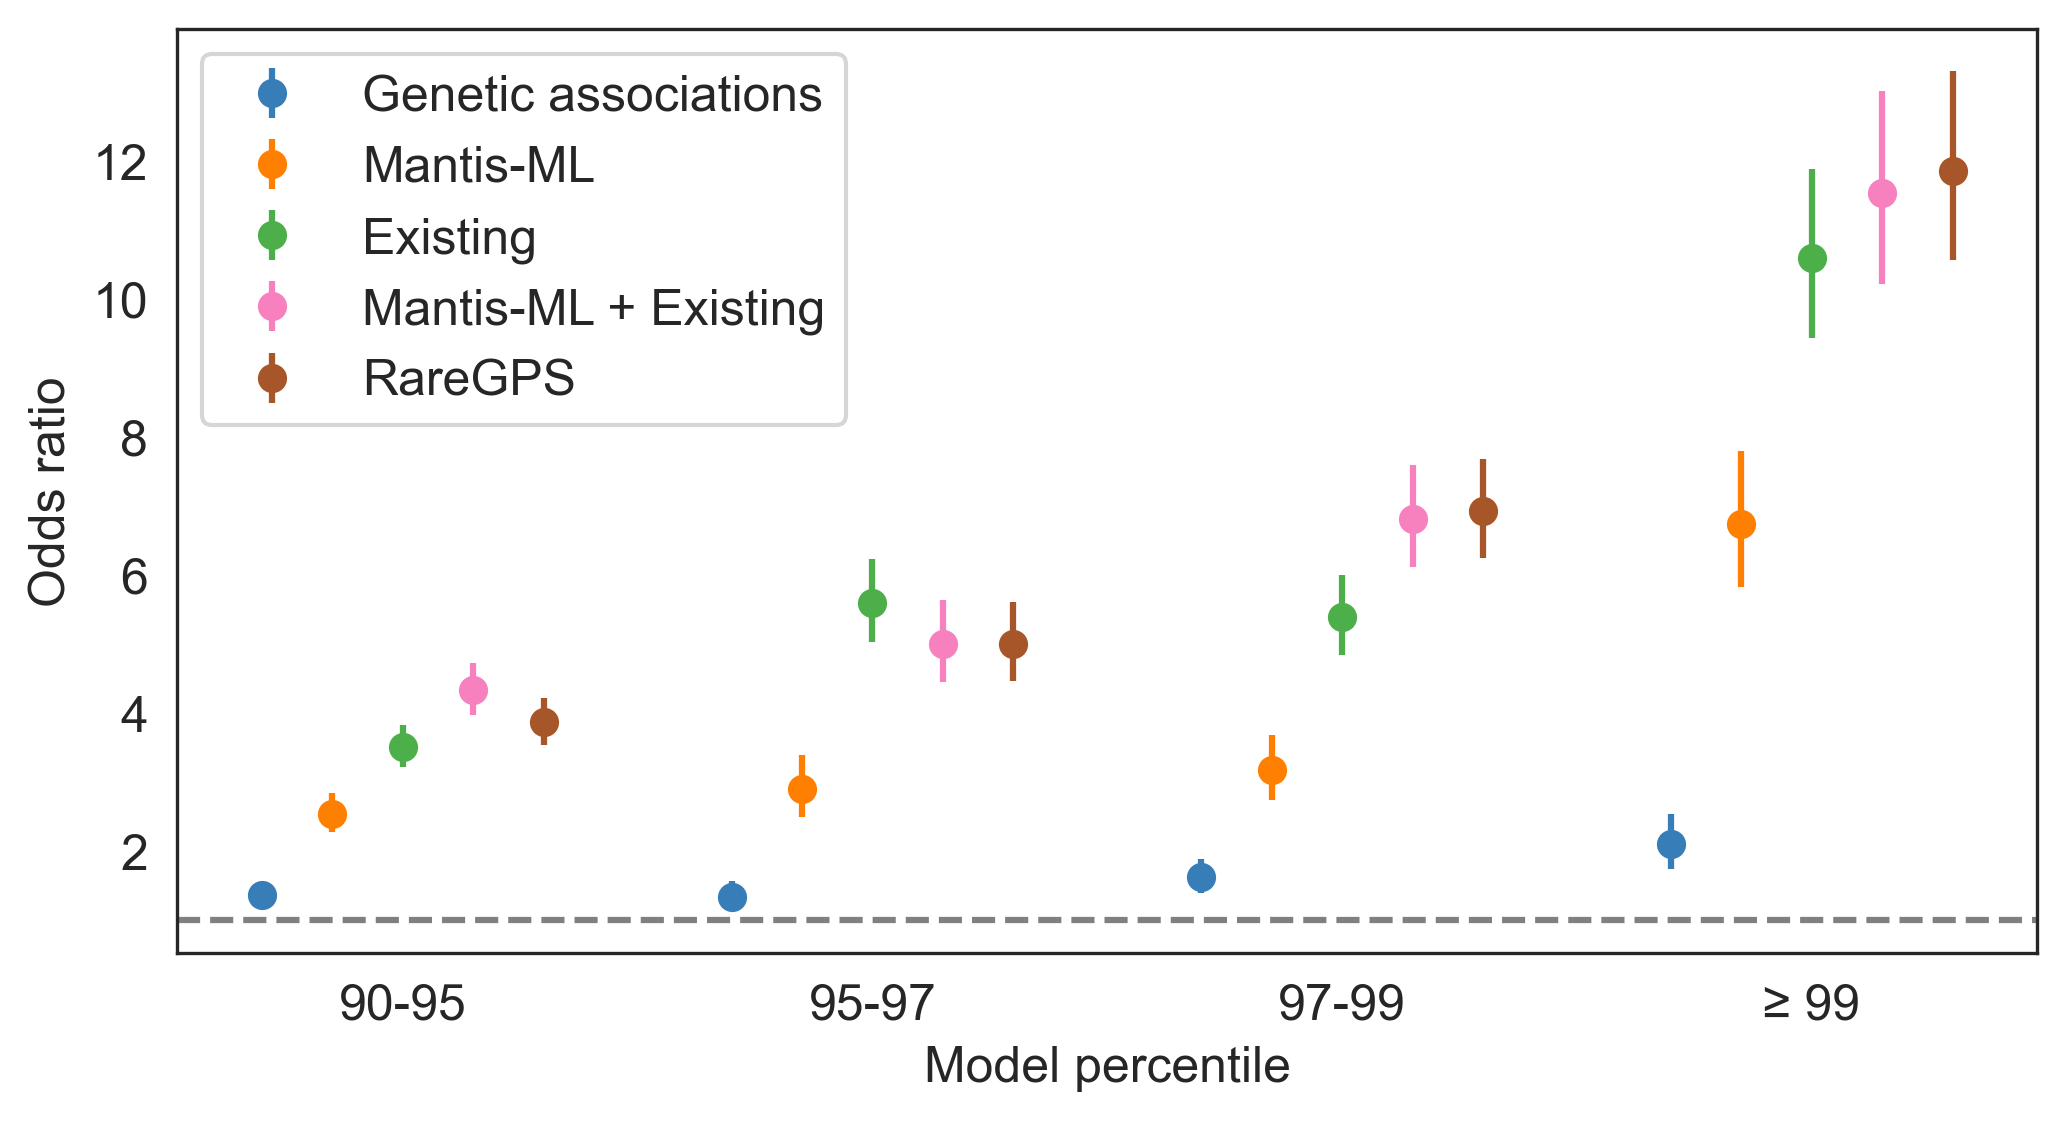

In [6]:
plot = pd.read_pickle('./Results/or_90_95_97.pkl')
plot['Condition'] = pd.Categorical(plot['Condition'], ['LOEUF','Genetic associations','Mantis-ML','Existing',
                                                       'Mantis-ML + Existing','RareGPS'])
plot['Percentile'] = pd.Categorical(plot['Percentile'], ['p_90','p_95','p_97','p_99'])
plot = plot.sort_values(['Condition','Percentile'])

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

diseases = plot['Percentile'].unique()
predictors = plot['Condition'].unique()

width = 0.15

for i, predictor in enumerate(predictors):
    predictor_data = plot[plot['Condition'] == predictor]
    x = np.arange(len(diseases))
    
    plt.errorbar(x + (i - (len(predictors) - 1) / 2) * width, predictor_data['Odds Ratio'],
                 yerr=[predictor_data['Odds Ratio'] - predictor_data['95% Lower'],
                       predictor_data['95% Upper'] - predictor_data['Odds Ratio']],
                 fmt='o', label=predictor, color=CB_color_cycle[i])

plt.xlabel('Model percentile')
plt.ylabel('Odds ratio')
plt.legend(title='',loc='upper left')

dl = ['90-95','95-97','97-99','≥ 99']
plt.xticks(np.arange(len(diseases)), dl, rotation=0, ha='center')

plt.axhline(y=1, color='gray', linestyle='--')

plt.show()

#### Synergy with DrugnomeAI

In [8]:
results = []

conds = ['ot_mantis_cc']        

for cond in conds:
    pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
    pdf = pdf.merge(indata[['id','phecode_category','Tclin']]).sort_values('prediction',ascending=False)
    pdf['percentile'] = pdf['prediction'].rank(pct=True) * 100
    pdf.loc[((pdf['percentile'] > 25) & (pdf['percentile'] < 75)), ['c_10','c_25','c_50','c_75',
                                                                    'd_10','d_25','d_50','d_75']] = 0
    pdf.loc[(pdf['percentile'] >= 99), 'd_10'] = 1
    pdf.loc[(pdf['percentile'] >= 99) & (pdf['Tclin'] >= 0.25), 'd_25'] = 1
    pdf.loc[(pdf['percentile'] >= 99) & (pdf['Tclin'] >= 0.50), 'd_50'] = 1
    pdf.loc[(pdf['percentile'] >= 99) & (pdf['Tclin'] >= 0.75), 'd_75'] = 1
    pdf.loc[pdf['id'].isin(pdf[:int(pdf['d_10'].sum())]['id']), 'c_10'] = 1
    pdf.loc[pdf['id'].isin(pdf[:int(pdf['d_25'].sum())]['id']), 'c_25'] = 1
    pdf.loc[pdf['id'].isin(pdf[:int(pdf['d_50'].sum())]['id']), 'c_50'] = 1
    pdf.loc[pdf['id'].isin(pdf[:int(pdf['d_75'].sum())]['id']), 'c_75'] = 1
    
    for col in ['c_10','c_25','c_50','c_75',
                'd_10','d_25','d_50','d_75']:
        temp = pdf.dropna(subset=col)
        X = temp[['phecode_category'] + [col]]
        X = pd.get_dummies(X, columns=['phecode_category'], drop_first=True).astype(float)
        X = sm.add_constant(X)
        y = temp['indication']
        
        model = sm.Logit(y, X)
        res = model.fit(disp=0, maxiter=1000)
        
        odds_ratio = np.exp(res.params[col])
        conf = res.conf_int().loc[col]
        conf_odds_ratio = np.exp(conf)
        p_value = res.pvalues[col]
        
        results.append({
            'Condition': cond,
            'Percentile': col,
            'Count': temp[col].sum(),
            'Odds Ratio': odds_ratio,
            '95% Lower': conf_odds_ratio[0],
            '95% Upper': conf_odds_ratio[1],
            'p-value': p_value
        })

res_df = pd.DataFrame(results)
res_df['Condition'] = res_df['Condition'].map({'cov':'LOEUF','otnopmc':'Existing (no PMC)','ot':'Existing',
                                             'mantis':'Mantis-ML','cc':'Genetics',
                                             'ot_mantis':'Existing + Mantis-ML',
                                             'ot_mantis_cc':'RareGPS',
                                             'otnopmc_cc':'RareGPS (partial)'})
res_df.to_pickle('./Results/or_90_95_97_drugnome.pkl')


In [9]:
res_df

,Condition,Percentile,Count,Odds Ratio,95% Lower,95% Upper,p-value
0,RareGPS,c_10,3563.0,11.855863,10.565121,13.304295,0.0
1,RareGPS,c_25,1967.0,15.228042,13.273147,17.470859,0.0
2,RareGPS,c_50,1726.0,16.369630,14.193500,18.879401,0.0
3,RareGPS,c_75,1491.0,17.954757,15.469986,20.838628,0.0
4,RareGPS,d_10,3563.0,11.855863,10.565121,13.304295,0.0
5,RareGPS,d_25,1967.0,16.888251,14.778089,19.299722,0.0
6,RareGPS,d_50,1726.0,18.079174,15.732904,20.775347,0.0
7,RareGPS,d_75,1491.0,20.291954,17.569237,23.436612,0.0


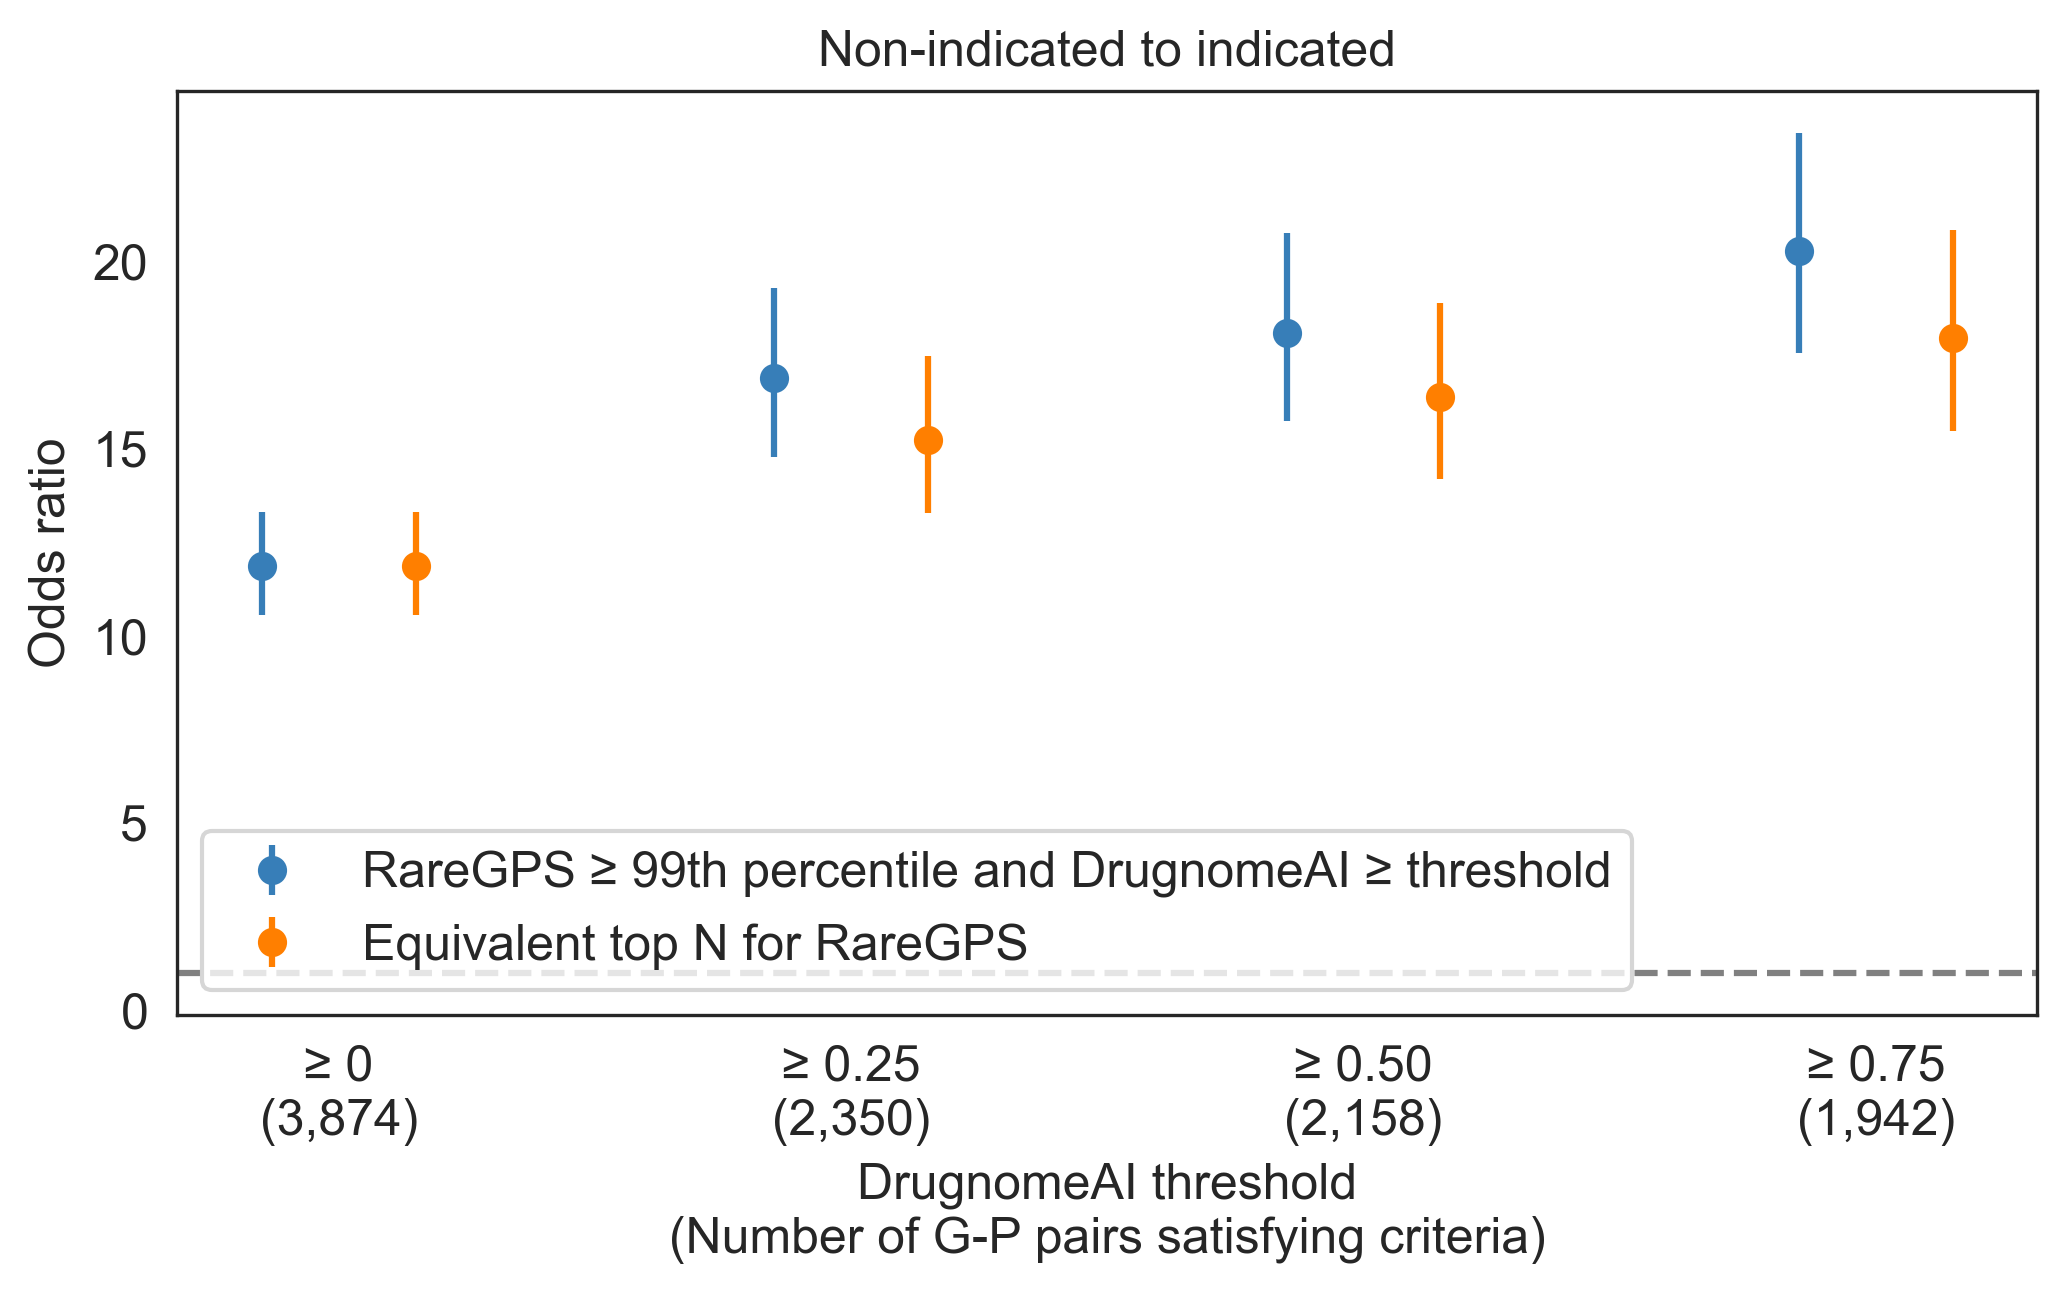

In [7]:
plot = pd.read_pickle('./Results/or_90_95_97_drugnome.pkl')
plot['Condition'] = 'Equivalent top N for RareGPS'
plot.loc[plot['Percentile'].str.contains('d'), 'Condition'] = 'RareGPS ≥ 99th percentile and DrugnomeAI ≥ threshold'
plot['Percentile'] = '0.' + plot['Percentile'].str.split('_').str[1]
plot['Condition'] = pd.Categorical(plot['Condition'], ['RareGPS ≥ 99th percentile and DrugnomeAI ≥ threshold',
                                                       'Equivalent top N for RareGPS'])
plot['Percentile'] = pd.Categorical(plot['Percentile'], ['0.10','0.25','0.50','0.75'])
plot = plot.sort_values(['Condition','Percentile'])

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

diseases = plot['Percentile'].unique()
predictors = plot['Condition'].unique()

width = 0.3

for i, predictor in enumerate(predictors):
    predictor_data = plot[plot['Condition'] == predictor]
    x = np.arange(len(diseases))
    
    plt.errorbar(x + (i - (len(predictors) - 1) / 2) * width, predictor_data['Odds Ratio'],
                 yerr=[predictor_data['Odds Ratio'] - predictor_data['95% Lower'],
                       predictor_data['95% Upper'] - predictor_data['Odds Ratio']],
                 fmt='o', label=predictor, color=CB_color_cycle[i])

plt.title('Non-indicated to indicated')
plt.xlabel('DrugnomeAI threshold\n(Number of G-P pairs satisfying criteria)')
plt.ylabel('Odds ratio')
plt.legend(title='',loc='lower left')

dl = ['≥ 0\n(3,874)','≥ 0.25\n(2,350)','≥ 0.50\n(2,158)','≥ 0.75\n(1,942)']
plt.xticks(np.arange(len(diseases)), dl, rotation=0, ha='center')

plt.axhline(y=1, color='gray', linestyle='--')

plt.show()
